In [1]:
import argparse
import pickle
from collections import namedtuple
import copy

import matplotlib.transforms as trs
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import patches
from matplotlib import animation
from IPython.display import HTML
# install package for displaying animation
!pip install JSAnimation

%matplotlib inline

import numpy as np
from collections import defaultdict
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler


  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11425 sha256=3d37abc6c0c0bcd1a1a0c346e6fe849431e8691175784ef6fad1fba3f881fb33
  Stored in directory: /root/.cache/pip/wheels/0e/4e/3d/05fb8cca2646ee0bbfbce17c40a970f48d5e0698b9e5aaa91f
Successfully built JSAnimation


# Hyper-Parameters

In [2]:
n=3
gamma=0.9
seed=0
render=True
log_interval=100
T = 100
num_O = 8
num_A = 2
MARL = False

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'a_log_p', 'r', 's_'])

# Neural Networks

In [3]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(num_O, 100)
        self.mu_head = nn.Linear(100, num_A)
        self.sigma_head = nn.Linear(100, num_A)

    def forward(self, x):
        x = F.relu(self.fc(x))
        mu = torch.tanh(self.mu_head(x))
        sigma = F.softplus(self.sigma_head(x))
        mu = torch.clamp(mu, 1e-10)
        sigma = torch.clamp(sigma, 1e-10)
        return (mu, sigma)


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(num_O, 100)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        state_value = self.v_head(x)
        return state_value

# Agent

In [4]:
class Agent():

    clip_param = 0.2
    max_grad_norm = 0.5
    ppo_epoch = 10
    buffer_capacity, batch_size = 1000, 128

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()
        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-4)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            (mu, sigma) = self.anet(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        action.clamp(-2.0, 2.0)
        return action.view(-1).numpy(), action_log_prob.view(-1).numpy()

    def get_value(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            state_value = self.cnet(state)
        return state_value.item()

    def save_param(self):
        torch.save(self.anet.state_dict(), 'param/ppo_anet_params.pkl')
        torch.save(self.cnet.state_dict(), 'param/ppo_cnet_params.pkl')

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.cat([torch.from_numpy(t.a.reshape(1,2)) for t in self.buffer], dim=0)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)

        old_action_log_probs = torch.cat(
            [torch.from_numpy(t.a_log_p.reshape(1,2)) for t in self.buffer], dim=0).view(-1, 2)

        r = (r - r.mean()) / (r.std() + 1e-5)
        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)

        adv = (target_v - self.cnet(s)).detach()

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                (mu, sigma) = self.anet(s[index])
                dist = Normal(mu, sigma)
                action_log_probs = dist.log_prob(a[index])
                ratio = torch.exp(action_log_probs - old_action_log_probs[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()

                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()

        del self.buffer[:]

# Environment

In [5]:
class RobotEnv(gym.Env):
  def __init__(self,n):
    self.n = n
    self.min_dist = 0.5

  def benchmark_data(self):
    costs = 0
    collisions = 0
    goal_reach = 0
    for i in range(self.n):
      dist = np.linalg.norm(self.goal_n[i] - self.state_n[i][:2])
      if dist < self.min_dist:
        goal_reach += 1
      costs -= dist
      
      min_dist = 1
      for j in range(self.n):
        if i==j: continue
        min_dist = min(min_dist, np.linalg.norm(self.state_n[j][:2] - self.state_n[i][:2]))
        if min_dist < self.min_dist: 
          collisions += 1
      
    return (goal_reach, collisions, costs)

  def step(self, action_n):
    state_n = [None] * self.n
    for i in range(self.n):
      v, r = action_n[i]
      px, py = self.state_n[i][0:2]
      theta = self.state_n[i][2] + r
      px = px + v * np.cos(theta)
      py = py + v * np.sin(theta)

      state_n[i] = np.array([px, py, theta])

    cost_n=[0]*self.n
    done_n=[0]*self.n
    safe_n=[True]*self.n
    for i in range(self.n):
      # Reach Goal
      dist = np.linalg.norm(self.goal_n[i] - state_n[i][:2])
      if dist < 0.5: 
        cost_n[i] = 10
        done_n[i] = True
      else: 
        cost_n[i] = -dist
        done_n[i] = False

        # Collide
        min_dist = 1.1
        for j in range(self.n):
          if i==j: continue
          min_dist = min(min_dist, np.linalg.norm(state_n[j][:2] - state_n[i][:2]))
        
        if min_dist < 1.0: 
          cost_n[i] -= 10
          safe_n[i] = False
    
    for i in range(self.n):
      # if safe_n[i] == False: continue
      self.state_n[i] = state_n[i]

    done = all(done_n)
    return self._get_obs(), cost_n, done, {}

  def _get_obs(self):
    obs_n = []
    for i in range(self.n):
      dist = self.goal_n[i] - self.state_n[i][:2]
      theta = self.state_n[i][2]
      heading = np.array([np.cos(theta), np.sin(theta)])
      for j in range(self.n):
        if j==i: continue
        dist_other = self.state_n[j][:2] - self.state_n[i][:2]
        theta_other = self.state_n[j][2]
        heading_other = np.array([np.cos(theta_other), np.sin(theta_other)])
      obs_n.append(np.hstack([dist, heading, dist_other, heading_other]))
    return obs_n
    
  def reset(self):
    self.state_n = []
    self.goal_n = []
    for i in range(self.n):
      theta = i * (np.pi * 2 / n) + np.pi / 2
      radius = 5
      sT = np.array([np.cos(theta), np.sin(theta)]) * radius
      s0 = np.array([-np.cos(theta), -np.sin(theta)]) * radius
      state = np.hstack([s0, theta])
      self.state_n.append(state)
      self.goal_n.append(sT)
    return self._get_obs()

  def render(self, path):
    self.fig, self.ax = plt.subplots(figsize=(7, 7))
    for i in range(self.n):
      x, y, theta = self.state_n[i]
      
      robot = plt.Circle([x,y], 0.5, fill=True, color='y')
      self.ax.add_artist(robot)
      robot.center = [x,y]

      vertices =[(-1/4,0), (1/4,0), (0, 1/2)] 
      polygon = patches.Polygon(vertices, color="red", alpha=0.50) 
      self.ax.add_artist(polygon)
      r = trs.Affine2D().rotate(theta-np.pi/2)
      t = trs.Affine2D().translate(x, y)
      tra = r + t + self.ax.transData
      polygon.set_transform(tra)
      x, y = self.goal_n[i]
      self.ax.add_artist(mlines.Line2D([x],[y], color='r', marker='*', linestyle='None', markersize=15, label='Goal'))  

      self.ax.scatter(path[:,i, 0], path[:,i,1])
    
    self.ax.set_xlabel('x(m)', fontsize=16)
    self.ax.set_ylabel('y(m)', fontsize=16)
    self.ax.set_xlim(-7, 7)
    self.ax.set_ylim(-7, 7)
    plt.show()

# Random Agent

In [ ]:

env = RobotEnv(n)
agents = [Agent() for _ in range(n)]

obs_n = env.reset()
traj = []

for t in range(T):
    traj.append(np.asarray(env.state_n).copy())
    action_n = []
    for i in range(n):
      agent = agents[i]
      action, action_log_prob = agent.select_action(obs_n[i])
      action_n.append(action)
    obs_n_, reward, done, _ = env.step(action_n)
    # env.render(np.asarray(traj))
    obs_n = obs_n_

# Training

Ep 0	 Score: -2480.25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Ep 100	 Score: -1997.79
Ep 200	 Score: -2412.29
Ep 300	 Score: -2188.45
Ep 400	 Score: -1532.00
Ep 500	 Score: -1144.99
Ep 600	 Score: -88.42
Ep 700	 Score: -89.78
Ep 800	 Score: -229.27
Ep 900	 Score: 560.27


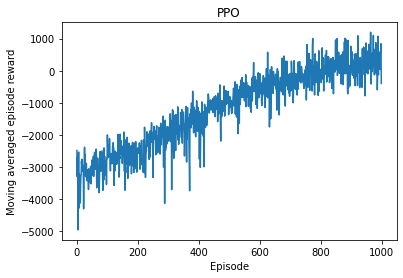

In [6]:
env = RobotEnv(n)
env.seed(seed)

agents = [Agent() for _ in range(n)]

training_records = []
obs_n = env.reset()

for i_ep in range(1000):
    score = 0
    obs_n = env.reset()
    for t in range(T):
      action_n = []
      action_log_prob_n=[]
      for i in range(n):
        agent = agents[i]
        action, action_log_prob = agent.select_action(obs_n[i])
        action_n.append(action)
        action_log_prob_n.append(action_log_prob)
        
      obs_n_, reward, done, _ = env.step(action_n)
      for i in range(n):
        agent = agents[i]
        r_signal = sum(reward) if MARL else reward[i]
        if agent.store(Transition(obs_n[i], action_n[i], action_log_prob_n[i], r_signal, obs_n_[i])):
            agent.update()
      score += sum(reward)
      obs_n = obs_n_
      if done: break

    training_records.append(TrainingRecord(i_ep, score))

    if i_ep % log_interval == 0:
        print(f'Ep {i_ep}\t Score: {score:.2f}')

plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
plt.title('PPO')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()


# Testing (video)

In [7]:
env = RobotEnv(n)
obs_n = env.reset()
traj = []
values = []
for t in range(T):
    traj.append(np.asarray(env.state_n).copy())
    action_n = []
    values.append(np.asarray([agents[i].get_value(obs_n[i]) for i in range(n)]))
    for i in range(n):
      agent = agents[i]
      action, action_log_prob = agent.select_action(obs_n[i])
      action_n.append(action)
    obs_n_, reward, done, _ = env.step(action_n)
    if any([r < -10 for r in reward]):
      print(f'collision in frame = {t} between agents {[i for i in range(n) if reward[i] < -10]}')

    # env.render(np.asarray(traj))
    obs_n = obs_n_


collision in frame = 5 between agents [0, 1, 2]


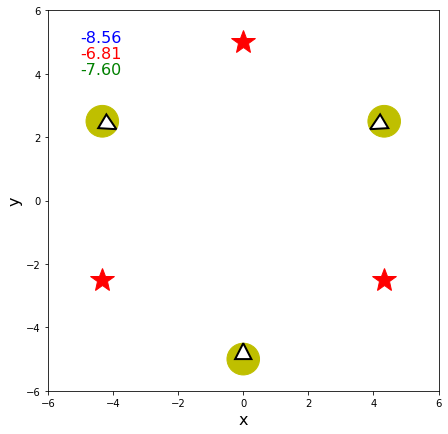

In [8]:
# create a figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

# set up the subplots as needed
ax.set_xlim(( -6, 6))            
ax.set_ylim((-6, 6))
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
txt_title = ax.set_title('')

robots=[]
polygons=[]
vals=[]
colors=['b','r','g']
for i in range(n):
  x, y, theta = traj[0][i]
  goal_x, goal_y = env.goal_n[i]
  ax.add_artist(mlines.Line2D([goal_x],[goal_y], color='r', marker='*', linestyle='None', markersize=25, label='Goal'))
  robots.append(plt.Circle([x, y], 0.5, fill=True, color='y'))
  ax.add_artist(robots[i])
  
  vals.append(plt.text(-5, 5-i/2, f'{values[0][i]:.2f}', fontsize=16, c=colors[i]))

  vertices =[(-1/4,0), (1/4,0), (0, 1/2)] 
  polygon = patches.Polygon(vertices, fc=(1,1,1,1), ec=(0,0,0,1), lw=2) 
  ax.add_artist(polygon)
  polygons.append(polygon)
  r = trs.Affine2D().rotate(theta-np.pi/2)
  t = trs.Affine2D().translate(x, y)
  tra = r + t + ax.transData
  polygon.set_transform(tra)

line1, = ax.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax.plot([], [], 'r', lw=2)
line3, = ax.plot([], [], 'g', lw=2)

In [9]:
def drawframe(time, path):
  for i in range(n):
    x, y, theta = path[time][i]
    robots[i].center = [x, y]
    r = trs.Affine2D().rotate(theta-np.pi/2)
    t = trs.Affine2D().translate(x, y)
    tra = r + t + ax.transData
    polygons[i].set_transform(tra)

    txt_title.set_text(f'Frame = {time}')
    vals[i].set_text(f'val = {values[time][i]:.2f}')
  line1.set_data(path[:time, 0, 0], path[:time, 0, 1])
  line2.set_data(path[:time, 1, 0], path[:time, 1, 1])
  line3.set_data(path[:time, 2, 0], path[:time, 2, 1])
  return (line1,line2,line3)

anim = animation.FuncAnimation(fig, drawframe, frames=T, interval=100, blit=True, fargs=(np.asarray(traj), ))
HTML(anim.to_html5_video())

In [ ]:
anim.save('myAnimation.gif', writer='pillow', fps=30)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.download("myAnimation.gif") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing Statistic

In [ ]:
env = RobotEnv(n)

num_test=500
num_stat=3
stats = np.zeros((num_test, T, num_stat))
dones=0
for ep in range(num_test):
  obs_n = env.reset()
  for t in range(T):
    action_n = []
    for i in range(n):
      agent = agents[i]
      action, action_log_prob = agent.select_action(obs_n[i])
      action_n.append(action)
    obs_n_, reward, done, _ = env.step(action_n)
    if done:
      dones+=1
    (goal_reach, collisions, costs) = env.benchmark_data()
    stats[ep][t][0:3] = goal_reach, collisions, costs
    obs_n = obs_n_


In [ ]:
def post_process(stats):
  y0 = stats[:, :, 0].mean() / n
  y1 = stats[:, :, 1].max(1).mean() / n
  y2 = stats[:, :, 2].mean() / 2
  print(f'avgerage goals reached: {y0*100:.2f}% \t collisions: {y1*100:.2f}% \t costs:  {y2*100:.2f}')

In [ ]:
post_process(stats)
print(f'goals reached: {dones/num_test*100:.2f}%')

avgerage goals reached: 17.36% 	 collisions: 23.40% 	 costs:  -286.79
goals reached: 84.20%


In [ ]:
post_process(stats)
print(f'goals reached: {dones/num_test*100:.2f}%')

avgerage goals reached: 5.88% 	 collisions: 20.13% 	 costs:  -495.91
goals reached: 4.20%
